In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%load_ext autoreload
%autoreload 2
from olist.seller import Seller
from olist.data import Olist
from olist.utils import *
from olist.product import Product
from olist.order import Order

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import plotly.express as px

/Users/emiliasato/.pyenv/versions/3.10.6/envs/ecommerce-analysis/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
product = Product().get_training_data()
seller = Seller().get_training_data()
order = Order().get_training_data(with_distance_seller_customer=True)

For each `seller_id` we need three items:  

- The **revenue**:

    - 10% fee on sales
    - 80 BRL per month on Olist

- The **cost**:
    - Review cost according to `{1: 100, 2: 50, 3: 40, 4: 0, 5: 0}` with review score as key and cost in BRL as value

- The **profit** made by Olist


In [23]:
#calculating the revenue
subscription_revenue = (seller['months_on_olist']*80).sum()
sales_revenue = (seller['sales']*0.1).sum()

#calculating the it cost
n_sellers = seller.nunique()['seller_id']
n_items = seller['quantity'].sum()
it_cost = 3157.27*sqrt(n_sellers) + 978.23*sqrt(n_items)

#calculating the total reputation cost
reputation_cost = seller['cost_of_reviews'].sum()

#calculating the gross profit
gross_profit = subscription_revenue + sales_revenue - reputation_cost - it_cost

financials = pd.DataFrame([
    ('Subscription Revenue',subscription_revenue),
    ('Sales Revenue',sales_revenue),
    ('Total Revenue',subscription_revenue + sales_revenue),
    ('IT Cost',it_cost),
    ('Reputation Cost',reputation_cost),
    ('Total Cost',it_cost + reputation_cost),
    ('Gross Profit',gross_profit),
    ('Profit Margin',gross_profit/(subscription_revenue + sales_revenue))]
)

financials.rename(columns = {0:'Items',1:'in BRL'},inplace=True)
financials_formatted = financials.round(2)
#financials_formatted[['in BRL']] = financials_formatted[['in BRL']].applymap(lambda x: "{:,}".format(x))


### Your current financials look like this!

In [15]:
dict(financials_formatted)

{'Items': 0    Subscription Revenue
 1           Sales Revenue
 2           Total Revenue
 3                 IT Cost
 4         Reputation Cost
 5              Total Cost
 6            Gross Profit
 7           Profit Margin
 Name: Items, dtype: object,
 'in BRL': 0     1,430,240.0
 1    1,355,578.44
 2    2,785,818.44
 3      499,999.32
 4     1,618,210.0
 5    2,118,209.32
 6      667,609.13
 7            0.24
 Name: in BRL, dtype: object}

In [16]:
# Create DataFrame
data = {
    'Items': ['Subscription Revenue', 'Sales Revenue', 'Total Revenue', 'IT Cost', 'Reputation Cost', 'Total Cost', 'Gross Profit', 'Profit Margin'],
    'in BRL': ['1,430,240.0', '1,355,578.44', '2,785,818.44', '499,999.32', '1,618,210.0', '2,118,209.32', '667,609.13', '0.24']
}

df = pd.DataFrame(data)

# Convert 'in BRL' to numeric, removing commas
df['in BRL'] = df['in BRL'].str.replace(',', '').astype(float)

In [24]:
df = financials_formatted

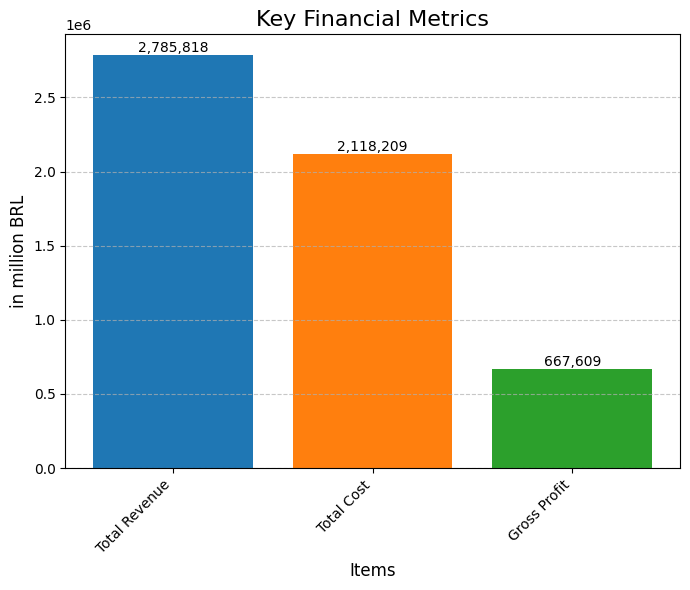

In [38]:
plt.figure(figsize=(7, 6))
items_to_plot = ['Total Revenue', 'Total Cost', 'Gross Profit']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.bar(financials_formatted[financials_formatted['Items'].isin(items_to_plot)]['Items'], 
        financials_formatted[financials_formatted['Items'].isin(items_to_plot)]['in BRL'],
        color=colors)

plt.title('Key Financial Metrics', fontsize=16)
plt.xlabel('Items', fontsize=12)
plt.ylabel('in million BRL', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(financials_formatted[financials_formatted['Items'].isin(items_to_plot)]['in BRL']):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

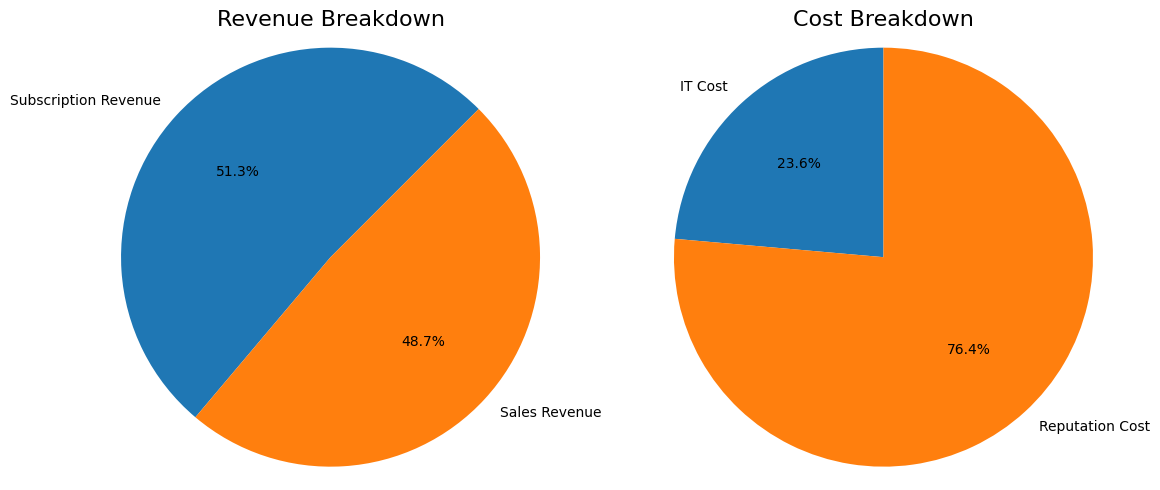

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Revenue Breakdown
revenue_data = financials_formatted[financials_formatted['Items'].isin(['Subscription Revenue', 'Sales Revenue'])]
axs[0].pie(revenue_data['in BRL'], labels=revenue_data['Items'], autopct='%1.1f%%', 
            startangle=45, labeldistance=1.1)  # Adjust labeldistance
axs[0].set_title('Revenue Breakdown', fontsize=16)
axs[0].axis('equal')

# Plot 2: Cost Breakdown
cost_data = financials_formatted[financials_formatted['Items'].isin(['IT Cost', 'Reputation Cost'])]
axs[1].pie(cost_data['in BRL'], labels=cost_data['Items'], autopct='%1.1f%%', 
            startangle=90, labeldistance=1.1)  # Adjust labeldistance
axs[1].set_title('Cost Breakdown', fontsize=16)
axs[1].axis('equal')

plt.tight_layout()
plt.show()



Key things to note:
- Total Revenue is around **2.8M BRL** - well diversified with around half from subscription and around half from sales
- REPUTATION COSTS ARE VERY DAMAGING
- Reputation Costs make up of more than **76%** of total costs $\rightarrow$ risk of losing more customers in the future!!

What if we simply remove the worst sellers?

In [7]:
sorted_sellers = seller.sort_values(by='profits', ascending=True, ignore_index=True)
def it_cost_recalc(df,num_to_remove):
    n_sellers = seller.nunique()['seller_id'] - num_to_remove
    n_items = df['quantity'].sum() - df['quantity'].values[:num_to_remove].sum()
    
    it_cost = 3157.27* sqrt(n_sellers) + 978.23*sqrt(n_items)
    return it_cost
change_in_it_cost = pd.DataFrame([it_cost_recalc(sorted_sellers,num) for num in range(2967)])
change_in_profit = pd.DataFrame([sorted_sellers['profits'].values[num:].sum() for num in range(2967)])
change_in_revenue= pd.DataFrame([sorted_sellers['revenues'].values[num:].sum() for num in range(2967)])
change_in_rep_cost = pd.DataFrame([sorted_sellers['cost_of_reviews'].values[num:].sum() for num in range(2967)])
change_in_profit_after_it = change_in_profit - change_in_it_cost
change_in_it_cost
change_in_it_cost[0]

0       499999.318519
1       496991.389117
2       494024.237152
3       491347.711731
4       489511.812301
            ...      
2962     51383.513743
2963     44339.889079
2964     41224.163282
2965     31254.985925
2966     22964.917828
Name: 0, Length: 2967, dtype: float64

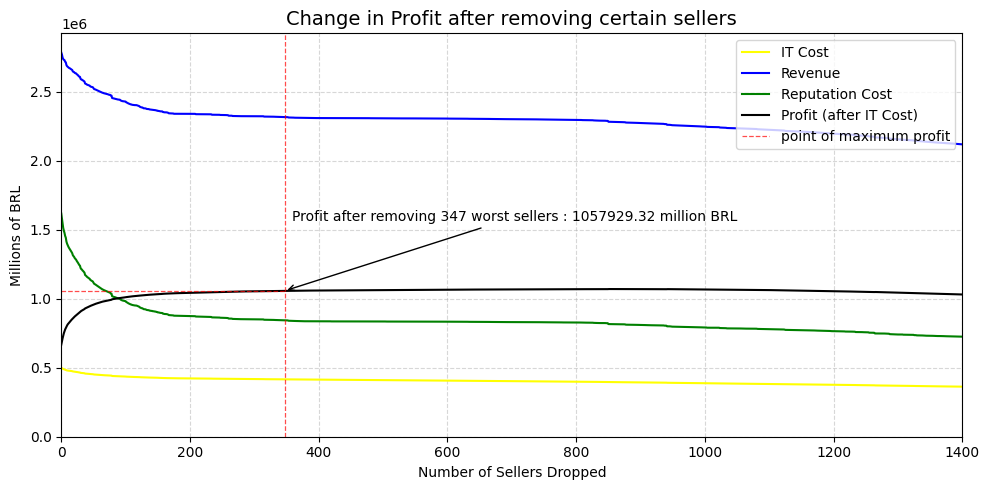

In [8]:
plt.figure(figsize=(10, 5))

# Plotting the lines
sns.lineplot(x=change_in_it_cost.index, y=change_in_it_cost[0], label='IT Cost', color='yellow', linestyle='-')
sns.lineplot(x=change_in_revenue.index, y=change_in_revenue[0], label='Revenue', color='blue', linestyle='-')
sns.lineplot(x=change_in_rep_cost.index, y=change_in_rep_cost[0], label='Reputation Cost', color='green', linestyle='-')
sns.lineplot(x=change_in_profit_after_it.index, y=change_in_profit_after_it[0], label='Profit (after IT Cost)', color='black', linestyle='-')

# Adding vertical line
plt.axvline(x=347, color='red', linestyle='--', label='point of maximum profit',linewidth=0.9, alpha=0.7)

# Formatting
plt.xlim(0, 1400)
plt.ylim(0, None)  # Adjust ylim as needed
plt.xlabel('Number of Sellers Dropped')
plt.ylabel('Millions of BRL')
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines
plt.legend(loc='upper right', frameon=True)  # Adjust legend position and style

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding annotation for y-value at x = 347
x_annotation = 347
y_annotation = change_in_profit_after_it.loc[x_annotation][0]
plt.annotate(f'Profit after removing 347 worst sellers : {y_annotation:.2f} million BRL',
             xy=(x_annotation, y_annotation), xycoords='data',
             xytext=(5, 50), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

# Adding horizontal line perpendicular to y = 347 line
plt.plot([0, x_annotation], [y_annotation, y_annotation], color='red', linestyle='--',linewidth=0.9, alpha=0.7)


# Title
plt.title('Change in Profit after removing certain sellers', fontsize=14)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

**You can expect to increase profit by 390K BRL just be removing the worst 347 sellers!**

In [9]:
product.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,10.91,0.0,1.0,5.0,0,1,1,10.91,1.091,1.091
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,15.771898,248.00,0.0,1.0,5.0,0,1,1,248.00,24.800,24.800
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,2.087674,79.80,0.0,1.0,5.0,0,1,1,79.80,7.980,7.980
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,3.262986,112.30,1.0,0.0,1.0,100,1,1,112.30,11.230,-88.770
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,2.899387,37.90,0.0,1.0,5.0,0,1,1,37.90,3.790,3.790


In [10]:
Product().get_product_cat()['profits'].sum()

-289896.9349999999

In [11]:
order

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08,69.481037
95876,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10,474.098245
95877,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02,968.051192
95878,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18,370.146853


###  Our Recommendation: 
## Olist can improve profit by 500k BRL by taking the following actions to improve customer reviews

### 1. Ban top loss-generating sellers
### 2. Ask customers to review each product separately
### 3. Sellers must post at least 2 pictures of the product

## Recommendation Number 1:
# Remove worst loss-generating sellers

As we have seen so far, Reputation Costs make up of more than **76%** of total costs so we should definitely cut these down...

What is driving the reputation costs? **Bad Review Scores!!**

And what is driving the bad review scores? **Wait Time!!**

Let's first take a look the correlation between review scores and various factors related to the order:

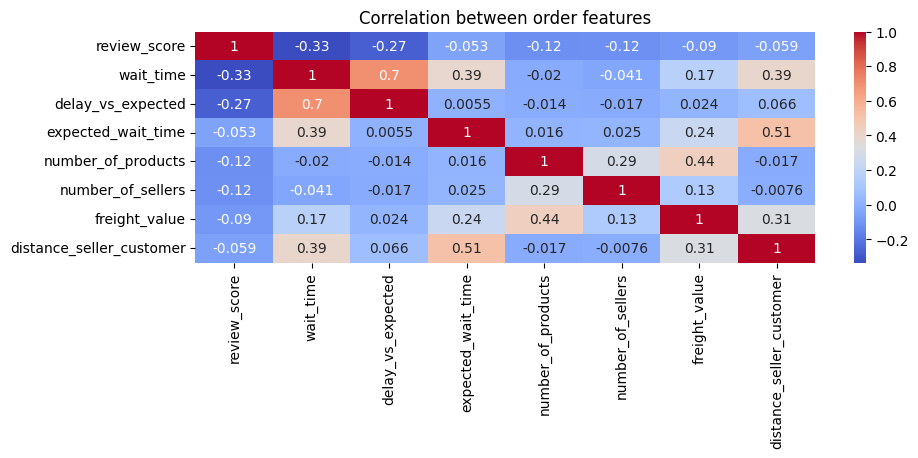

In [12]:
plt.figure(figsize = (10,3))
corr_features = ['review_score','wait_time','delay_vs_expected','expected_wait_time','number_of_products',
                    'number_of_sellers','freight_value','distance_seller_customer']
sns.heatmap(order[corr_features].corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10})
plt.title('Correlation between order features');

$\rightarrow$  You can see that there is a relatively strong negative correlation between review score and wait time/delay_vs_expected

In [13]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized
standardized_orders = standardize(order,selected_features)

NameError: name 'selected_features' is not defined

In [ ]:
logit_features = ['wait_time','expected_wait_time','delay_vs_expected','number_of_products','number_of_sellers','distance_seller_customer']
formula = f"dim_is_one_star ~ {' + '.join(logit_features)}"
logit_model = smf.logit(formula=formula, data=standardized_orders).fit();
logit_model.summary()

To get a better representation, let's now look at the results of a logistic regression we ran against some relevant order features against the probability of getting a review score of 1. 

In [ ]:
plt.figure(figsize=(6,3))
logit_model.params[1:].sort_values().plot(kind='barh')
plt.xlabel('logistic regression coefficient')
plt.ylabel('features')
plt.title('order features logistically regressed against probability of getting a review score of 1');

Key Findings:
- As you can see, **wait time** drives bad review scores the most which is consistent with what we saw in the previous slide
- In addition, we can also see that the **number of products** and **number of sellers** per order is also impacting the review score negatively, which we will touch on later. 

For now, lets focus on how to reduce the overall wait time because it has the strongest relationship with low review scores. 

$\rightarrow$ wait time is made up of both the seller's shipping delay and carrier's delay

$\rightarrow$ Carrier delay is out of our control, so we should be selecting only the profit generating sellers who will ship the products on time!

In [ ]:
plt.figure(figsize=(10,4))
sns.scatterplot(
    data=seller,
    x="wait_time",
    y="delay_to_carrier",
    #size="size",  # This is the normalized and scaled 'sales' data
    hue="review_score",  # Color by 'review_score'
    palette="viridis",  # Color palette
    alpha=0.8,
    #sizes=(20, 200)  # Adjust size range as needed; (min_size, max_size),
    legend=None
)
norm = plt.Normalize(seller['review_score'].min(), seller['review_score'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Review Score')

plt.title("Scatter Plot of Sellers by Wait Time and Delay")
plt.xlabel("Wait Time")
plt.ylabel("Delay to Carrier")
plt.show()

so, what happens when we remove the worst loss-generating sellers?

Below shows the change in your key financials as we remove the worst loss-generating sellers one by one

## Recommendation Number 2:
# Ask customers to review each product separately

Why?
- number of products and number of sellers are also driving factors of getting low review scores
- There are also chances of penalizing sellers and products that were bundle purchased with bad products/bad sellers

In [ ]:
plt.figure(figsize=(5,3))
logit_model.params[1:].sort_values().plot(kind='barh')
plt.xlabel('logistic regression coefficient')
plt.ylabel('features')
plt.title('order features logistically regressed against probability of getting a review score of 1');

## Recommendation Number 3:
# Sellers must post at least 2 pictures of the product

Why?
- linear regression shows that number of photo quantity has a slightly positive relationship with review scores
- Fairly easy rule to implement so why not?

In [ ]:
product['product_volume_cm3'] = product["product_length_cm"] * product["product_height_cm"] * product["product_width_cm"]
product_features =  [
    'product_photos_qty',
    'product_volume_cm3',
    'wait_time',
    'price',
]
product_logit_features = [
    'product_photos_qty',
    'product_volume_cm3',
    'wait_time',
    'price',
    'review_score'
]
standardized_products = standardize(product,product_features)

In [ ]:
formula = 'review_score' + ' ~ ' + ' + '.join(product_features)
product_model = smf.ols(formula = formula,data=standardized_products).fit()
product_model.summary()

In [ ]:
product_model.params[1:].sort_values().plot(kind='barh')
plt.title('product features linearly regressed against review_score');

## Thank you for listening!
## Hope you make the right decision!